# Model

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_event_detector():
    model = models.Sequential([
        layers.Input(shape=(250, 1)),
        layers.Conv1D(8, kernel_size=7, activation='relu'),
        layers.MaxPooling1D(pool_size=2),
        layers.Conv1D(16, kernel_size=5, activation='relu'),
        layers.MaxPooling1D(pool_size=2),
        layers.Flatten(),
        layers.Dense(32, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    return model


# Generating Data

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def generate_eeg_background(duration_sec=10, fs=250):
    t = np.linspace(0, duration_sec, fs * duration_sec)
    eeg = (
        30 * np.sin(2 * np.pi * 10 * t) +
        15 * np.sin(2 * np.pi * 4 * t) +
        5 * np.sin(2 * np.pi * 60 * t) +
        5 * np.random.randn(len(t))
    )
    return t, eeg

def insert_spikes(eeg, fs, spike_count=10):
    eeg = eeg.copy()
    spike_template = np.exp(-np.linspace(-2, 2, fs//10)**2) * 100  # 100 ms spike
    spike_len = len(spike_template)

    spike_indices = np.random.randint(fs, len(eeg) - spike_len, spike_count)
    for idx in spike_indices:
        eeg[idx:idx + spike_len] += spike_template
    return eeg, spike_indices

def plot_eeg_with_spikes(t, eeg, spike_indices, fs):
    plt.figure(figsize=(12, 4))
    plt.plot(t, eeg, label='EEG Signal', color='blue')
    spike_times = t[spike_indices]
    plt.scatter(spike_times, eeg[spike_indices], color='red', label='Injected Spikes', zorder=3)
    plt.title("Synthetic EEG with Injected Spikes")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude (µV)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()




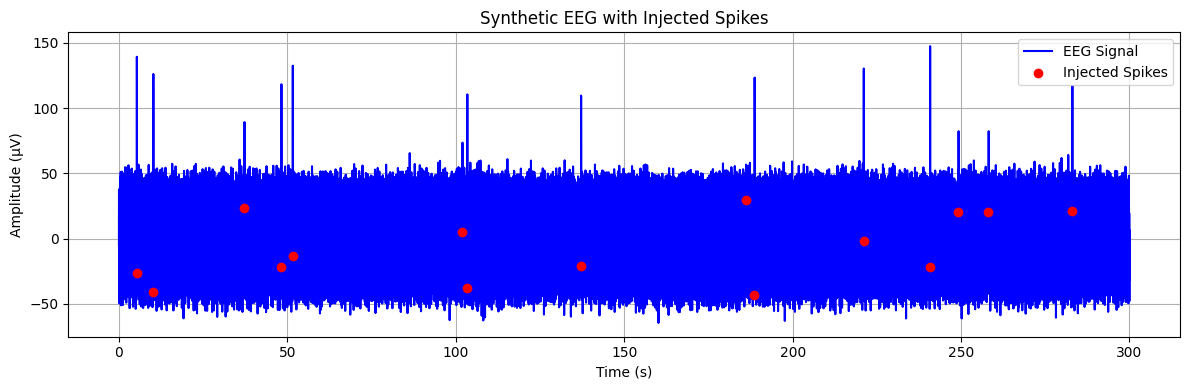

In [ ]:
    fs = 250
    duration_sec = 300
    spike_count = 15

    t, eeg = generate_eeg_background(duration_sec, fs)
    eeg_spike, spike_locs = insert_spikes(eeg, fs, spike_count)
    plot_eeg_with_spikes(t[:fs*duration_sec], eeg_spike[:fs*duration_sec], spike_locs, fs)

# Training Model

In [ ]:
from sklearn.model_selection import train_test_split
def generate_windows(eeg, spike_indices, fs=250):
  X = []
  y = []
  window_len = fs
  for i in range(0, len(eeg) - window_len, window_len):
    segment = eeg[i:i + window_len]
    label = int(np.any((spike_indices >= i) & (spike_indices < i + window_len)))
    X.append(segment)
    y.append(label)
  return np.array(X), np.array(y)

X, y = generate_windows(eeg_spike, spike_locs, fs)
X = X[..., np.newaxis]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

In [ ]:
model = build_event_detector()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=15, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9368 - loss: 0.5616 - val_accuracy: 0.9500 - val_loss: 0.4772
Epoch 2/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9513 - loss: 0.3951 - val_accuracy: 0.9500 - val_loss: 0.2047
Epoch 3/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9514 - loss: 0.1951 - val_accuracy: 0.9500 - val_loss: 0.3041
Epoch 4/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9603 - loss: 0.1665 - val_accuracy: 0.9667 - val_loss: 0.2170
Epoch 5/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9870 - loss: 0.0426 - val_accuracy: 0.9667 - val_loss: 0.2363
Epoch 6/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 1.0000 - loss: 0.0204 - val_accuracy: 0.9667 - val_loss: 0.2760
Epoch 7/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 0.0098 - val_accuracy: 0.9667 - val_loss: 0.2984
Epoch 8/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 1.0000 - loss: 0.0072 - val_accuracy: 0.9667 - val_loss: 0.3189


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


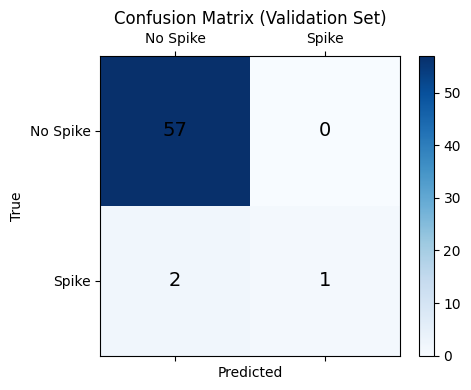

              precision    recall  f1-score   support

    No Spike       0.97      1.00      0.98        57
       Spike       1.00      0.33      0.50         3

    accuracy                           0.97        60
   macro avg       0.98      0.67      0.74        60
weighted avg       0.97      0.97      0.96        60



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
y_pred_probs = model.predict(X_val)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

cm = confusion_matrix(y_val, y_pred)
classes = ["No Spike", "Spike"]

fig, ax = plt.subplots(figsize=(5, 4))
cax = ax.matshow(cm, cmap="Blues")
fig.colorbar(cax)

ax.set_xticks(np.arange(len(classes)))
ax.set_yticks(np.arange(len(classes)))
ax.set_xticklabels(classes)
ax.set_yticklabels(classes)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("Confusion Matrix (Validation Set)")


for (i, j), val in np.ndenumerate(cm):
    ax.text(j, i, f'{val}', ha='center', va='center', fontsize=14, color='black')

plt.tight_layout()
plt.show()

print(classification_report(y_val, y_pred, target_names=classes))

# Converting to TFLite

In [ ]:
import tensorflow as tf

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]  # post-training quantization
tflite_model = converter.convert()

with open('event_detector.tflite', 'wb') as f:
    f.write(tflite_model)

Saved artifact at '/tmp/tmpm0by4u83'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 250, 1), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  137727294534672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137727294537360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137727294534864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137727294535056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137727294029904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137727294031440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137727294537552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137727294030672: TensorSpec(shape=(), dtype=tf.resource, name=None)
